# Projet d'Optimisation - Rangement d'un tuyau de jardin

# Enol Alvarez & Louis-Justin Tallot

## 1. Etude du problème d'optimisation

#### Q1) Interpréter le coût (4). Que cherche-t-on à minimiser ?

On cherche $min \left(K\left(x_N - \dfrac{L}{2}\right)^2 + \text{d}x^2 \sum \limits _{i=0}^N y_i^2   \right)$

-> distance à l'horizontale + distance au parterre de fleurs

#### Q2) Pourquoi n'a-t-on pas plutôt imposé la contrainte $x_N = L/2$ ?

#### Q3) Interpréter géométriquement la condition de courbure (5)

On impose une courbure maximale avec : 

$$
    (x_{i+1} - 2x_i + x_{i-1})^2 + (y_{i+1} - 2y_i + y_{i-1})^2 \leq \text{d}x^4 \gamma^2
$$

En écrivant : 

#### Q4) Formuler le problème d'optimisation à résoudre sous la forme 

$$ \min \limits _{c_{eq}(z)=0,\; c_{ineq}(z)=0} f(z)$$

On pose : 

Variables de décision au nombre $n=2N+2$ : 
$$z = (x_0, \dots, x_N , y_0, \dots, y_N)$$  


Contraintes : 

 $$
\begin{align} 

c_{eq}(z) &= c_{eq}(x_0, \dots, x_N , y_0, \dots, y_N) \\
          &= (x_0, y_0, y_N , (x_1-x_0)^2 + (y_1-y_0)^2-\text{d}x^2, \dots, (x_N-x_{N-1})^2 + (y_N-y_{N-1})^2-\text{d}x^2)

\end{align}

 $$


 $$
\begin{align} 

c_{ineq}(z) &= c_{ineq}(x_0, \dots, x_N , y_0, \dots, y_N) \\
          &= (x_0-x_1, \dots, x_{N-1}-x_N, 
          (x_2-2x_1+x_0)^2+(y_2-2y_1+y_0)^2- \text{d} x ^4 \gamma ^2, \dots, 
        (x_N-2x_{N-1}+x_{N-2})^2+(y_N-2y_{N-1}+y_{N-2})^2- \text{d} x ^4 \gamma ^2)

\end{align}
 $$

Fonction objectif à minimiser : 

$$
\begin{align}
  f(z) &= f(x_0, \dots, x_N , y_0, \dots, y_N) \\
       &= K \left(( _N - \dfrac{L}{2}\right)^2 + \text{d}x^2 \sum_{i=0}^N y_i^2 

\end{align}
$$



## 2. Etude et résolution numériques

#### Q5) Quelles méthodes de résolution peuvent être envisagées pour ce problème ?

#### Q6) Développer un algorithme de résolution pour les valeurs numériques suivantes : $L = 10$ ; $N = 60$ ; $K= 10$ et $\gamma = 3$

In [111]:
import casadi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.utils import io

In [95]:
# nos données
L = 10
N = 60
K = 10
gamma = 3

# on en déduit alors
dx = L/N

In [103]:
# Condition initiale - triangle rectangle isocèle
# les y d'abord
y = []
res = 0
while res <= L/(2*np.sqrt(2)):
    y.append(res)
    res += dx / (np.sqrt(2))

res = L/(2*np.sqrt(2)) - dx/(2*np.sqrt(2))
while res >= 0:
    y.append(res)
    res -= dx/np.sqrt(2)

# puis les x

x = []
res = 0

while res <= L/(np.sqrt(2)):
    x.append(res)
    res += dx/np.sqrt(2)
x.append(L/(np.sqrt(2)))

z0 = np.array(y+x)

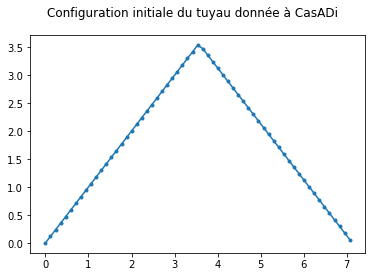

In [101]:
X = [z0[i] for i in range(N+1, 2*N+2)]
Y = [z0[i] for i in range(0, N+1)]
plt.plot(X, Y, marker='.')
plt.suptitle("Configuration initiale du tuyau donnée à CasADi")
plt.show()

In [112]:
def optim_simple(L=10, N=60, K=10, gamma=3, plot=True):
    dx = L/N

    # on lance une optimisation avec CasADi
    opti = casadi.Opti()
    # nombre de variables : 
    n = 2 * N + 2
    # notre variable d'optimisation dans CasADi, avec nos notations : 
    z = opti.variable(n)
    # notre fonction à minimiser : 
    f = 0
    # on met les y d'abord : 
    for i in range(N+1):
        f += dx**2 *z[i]**2

    f += K * (z[-1] - L/2)**2

    # on veut minimiser
    opti.minimize(f)
    # on rajoute les contraintes égalité
    opti.subject_to(z[0] == 0) # y_0
    opti.subject_to(z[N] == 0) # y_N
    opti.subject_to(z[N+1] == 0) # x_0

    for i in range(N):
        opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

    # on rajoute les contraintes inégalité
    for i in range(N):
        opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

    for i in range(N-1):
        opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    


    # CI
    opti.set_initial(z,z0)

    # on résoud
    opti.solver('ipopt')

    with io.capture_output() as captured:
        sol = opti.solve()

    result = sol.value(z)

    if plot:
        plt.figure()
        X = [result[i] for i in range(N+1, 2*N+2)]
        Y = [result[i] for i in range(0, N+1)]
        plt.plot(X, Y, marker='.')
        plt.axis('equal')
        plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")
        plt.show()

    return result


In [40]:
# on lance une optimisation avec CasADi
opti = casadi.Opti()
# nombre de variables : 
n = 2 * N + 2
# notre variable d'optimisation dans CasADi, avec nos notations : 
z = opti.variable(n)
# notre fonction à minimiser : 
f = 0
# on met les y d'abord : 
for i in range(N+1):
    f += dx**2 *z[i]**2

f += K * (z[-1] - L/2)**2

# on veut minimiser
opti.minimize(f)
# on rajoute les contraintes égalité
opti.subject_to(z[0] == 0) # y_0
opti.subject_to(z[N] == 0) # y_N
opti.subject_to(z[N+1] == 0) # x_0

for i in range(N):
    opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

# on rajoute les contraintes inégalité
for i in range(N):
    opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

for i in range(N-1):
    opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    



In [105]:
# CI
opti.set_initial(z,z0)

# on résoud
opti.solver('ipopt')
sol = opti.solve()
# print(sol.value(z))

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      596
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

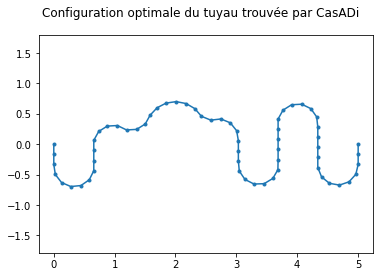

In [46]:
result = sol.value(z)
X = [result[i] for i in range(N+1, 2*N+2)]
Y = [result[i] for i in range(0, N+1)]
plt.plot(X, Y, marker='.')
plt.axis('equal')
plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")
plt.show()

## 3. Modèle global

In [91]:
x_P = 2
y_P = 1.3
R = 1

In [92]:
# on lance une optimisation avec CasADi
opti = casadi.Opti()
# nombre de variables : 
n = 2 * N + 2
# notre variable d'optimisation dans CasADi, avec nos notations : 
z = opti.variable(n)
# notre fonction à minimiser : 
f = 0
# on met les y d'abord : 
for i in range(N+1):
    f += dx**2 *z[i]**2

f += K * (z[-1] - L/2)**2

# on veut minimiser
opti.minimize(f)
# on rajoute les contraintes égalité
opti.subject_to(z[0] == 0) # y_0
opti.subject_to(z[N] == 0) # y_N
opti.subject_to(z[N+1] == 0) # x_0

for i in range(N):
    opti.subject_to((z[N+1 + i+1]-z[N+1 + i])**2 + (z[i+1]-z[i])**2 - dx**2 == 0)

# on rajoute les contraintes inégalité
for i in range(N):
    opti.subject_to(z[N+1 + i] - z[N+1 + i+1] <= 0)

for i in range(N-1):
    opti.subject_to((z[N+1 + i+2] - 2*z[N+1 + i+1] + z[N+1 + i])**2 + (z[i+2] - 2*z[i+1] + z[i])**2 - dx**4 * gamma**2 <= 0)    

# on rajoute le parterre de fleurs

for i in range(N+1):
    opti.subject_to(R**2 - (x_P-z[N+1 +i])**2 - (y_P-z[i])**2  <= 0)


In [106]:
# CI
opti.set_initial(z,z0)

# on résoud
opti.solver('ipopt')
sol = opti.solve()
# print(sol.value(z))

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      243
Number of nonzeros in inequality constraint Jacobian.:      596
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

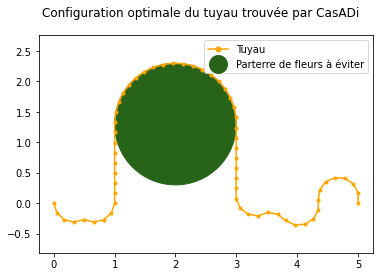

In [107]:
# les couleurs pour que ça soit joli
couleur_tuyau = "orange"
# couleur_parterre = matplotlib.cm.gist_earth(0.6)
couleur_parterre = matplotlib.cm.PiYG(0.999)


result = sol.value(z)
X = [result[i] for i in range(N+1, 2*N+2)]
Y = [result[i] for i in range(0, N+1)]
plt.plot(X, Y, marker='.', color=couleur_tuyau)
plt.axis('equal')
plt.suptitle("Configuration optimale du tuyau trouvée par CasADi")

parterre_fleurs = plt.Circle((x_P, y_P), R, color=couleur_parterre)


legende_tuyau = plt.Line2D(range(1), range(1),
                           marker="o", color=couleur_tuyau)


# plt.legend(handles=[matplotlib.patches.Patch(color=couleur_tuyau, label="Tuyau")])

line1 = plt.Line2D([], [], color=couleur_tuyau, 
                   marker='o',markersize=5, markerfacecolor=couleur_tuyau)
line2 = plt.Line2D([], [], color="white", 
                   marker='o',markersize=20,markerfacecolor=couleur_parterre)
plt.legend((line1,line2),('Tuyau','Parterre de fleurs à éviter'))#,numpoints=1, loc=1)
plt.gca().add_artist(parterre_fleurs)
plt.show()

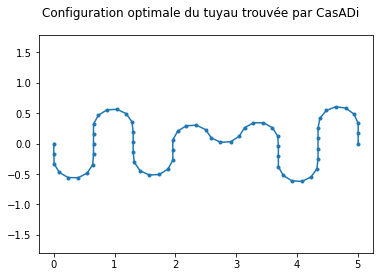

array([ 3.57526963e-33, -1.66666667e-01, -3.33236007e-01, -4.76227086e-01,
       -5.59892084e-01, -5.63314723e-01, -4.85639342e-01, -3.46284814e-01,
       -1.80089817e-01, -1.34231507e-02,  1.53243516e-01,  3.19910183e-01,
        4.65743487e-01,  5.54285052e-01,  5.63399457e-01,  4.90808097e-01,
        3.54658838e-01,  1.88989040e-01,  2.23223733e-02, -1.44344293e-01,
       -3.10014090e-01, -4.46163343e-01, -5.18754693e-01, -5.09640277e-01,
       -4.21098702e-01, -2.75265393e-01, -1.08598726e-01,  5.80679403e-02,
        2.03901259e-01,  2.92442852e-01,  3.01557290e-01,  2.28965962e-01,
        9.28167256e-02,  2.02253850e-02,  2.93398065e-02,  1.17881381e-01,
        2.59351328e-01,  3.40479599e-01,  3.40984097e-01,  2.60738699e-01,
        1.19804780e-01, -4.65841315e-02, -2.13250798e-01, -3.79917465e-01,
       -5.25750775e-01, -6.14292351e-01, -6.23406770e-01, -5.50815422e-01,
       -4.14666170e-01, -2.48996374e-01, -8.23297072e-02,  8.43369594e-02,
        2.51003626e-01,  

In [113]:
optim_simple()